In [1]:
import numpy
from scipy import signal
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import os, os.path
from scipy.io.wavfile import read as wavread
import math

import numpy as np

In [2]:
def block_audio(x, blockSize, hopSize, fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])

    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    x = np.concatenate((x, np.zeros(blockSize)), axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0, blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return xb, t


def fourier(x):
    # Get Symmetric fft
    w = signal.windows.hann(np.size(x))
    windowed = x * w
    w1 = int((x.size + 1) // 2)
    w2 = int(x.size / 2)
    fftans = np.zeros(x.size)

    # Centre to make even function
    fftans[0:w1] = windowed[w2:]
    fftans[w2:] = windowed[0:w1]
    X = fft(fftans)
    magX = abs(X[0:int(x.size // 2 + 1)])
    return magX

In [3]:
def extract_spectral_flux(xb):
    magX = np.zeros((xb.shape[0], int(xb.shape[1]/2 + 1)))
    specflux = np.zeros((xb.shape[0]))
    magX[0] = fourier(xb[0])
    for block in np.arange(1, xb.shape[0]):
        magX[block] = fourier(xb[block])
        den = magX[block].shape[0]
        specflux[block] = np.sqrt(np.sum(np.square(magX[block] - magX[block-1])))/den
    return specflux


In [4]:
def peakPicking(onsets, windowSize = 1024, threshold = 1):

    peaks = []
    
    peaks = peaksAboveAverage(onsets, windowSize)

    # Compute a windowed (moving) average
    #movingAverage = windowedAverage(onsets, windowSize)

    #peaks = peakdet(movingAverage, 1, threshold = threshold)

    #for i in range(0, len(movingAverage) - 1):
    #    if movingAverage[i] > movingAverage[i + 1]:
    #        peaks.append(movingAverage[i])
    #    else:
    #        peaks.append(0)
    return peaks

def peaksAboveAverage(data, windowSize):
    """
    Find peaks by the following method:
    - Compute the average of all the data
    - Using a non-sliding window, find the max within each window
    - If the windowed max is above the average, add it to peaks
    """

    data = numpy.array(data)

    peaks = []

    dataAverage = numpy.average(data)
    dataAverage = dataAverage * 1

    slideAmount = int(windowSize / 2)

    start = 0
    end = windowSize
    while start < len(data): 
        #print "Start: " + str(start)
        #print "End:   " + str(end)
        windowMax = data[start:end].max()  
        windowMaxPos = data[start:end].argmax()

        if windowMax > dataAverage:
            if (start + windowMaxPos) not in peaks:
                peaks.append(start + windowMaxPos)

        start = start + slideAmount
        end = end + slideAmount
    
    return peaks


def windowedAverage(data, windowSize):
    window = numpy.repeat(1.0, windowSize) / windowSize
    return numpy.convolve(data, window)[windowSize - 1 : -(windowSize - 1)]

def peakdet(v, delta, x = None, threshold = 1):
    """
    Adapted from code at: https://gist.github.com/250860
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    Returns two arrays
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))

    v = asarray(v)

    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')

    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')

    if delta <= 0:
        sys.exit('Input argument delta must be positive')

    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN

    lookformax = True

    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx - delta and this > threshold:
                #maxtab.append((mxpos, mx))
                maxtab.append(mxpos)
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                #mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    #return array(maxtab), array(mintab)
    return maxtab

In [5]:
path = '/Volumes/NoelHDD/Music_Tech/Datasets/Guitar_nyu/audio_hex-pickup_original/02_Funk1-97-C_solo_hex.wav'

In [6]:
fs, x = wavread(path)
x = x.flatten()
x = x/np.max(x)

Text(0, 0.5, 'Samples')

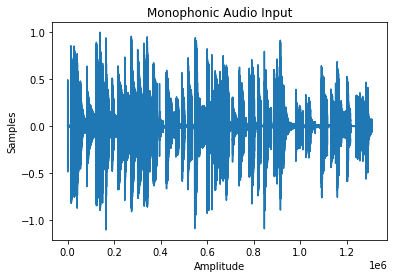

In [7]:

x = x
plt.plot(x)
plt.title("Monophonic Audio Input")
plt.xlabel("Amplitude")
plt.ylabel("Samples")

In [8]:
xb,t = block_audio(x,1024,256,fs)

In [9]:
spec_flux = extract_spectral_flux(xb)

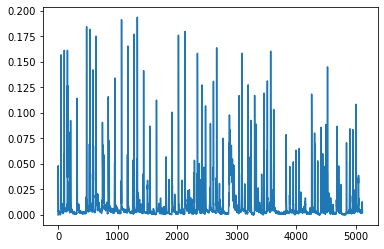

In [10]:
plt.plot(spec_flux)


In [13]:
peaks = peakPicking(spec_flux, windowSize = 10, threshold = 1)
peaks = [256 * p for p in peaks]
from scipy.signal import find_peaks
peaks1, _ = find_peaks(spec_flux, distance=150)
peaks1 = peaks1*256
len(peaks1)

26

In [15]:
peakdet(spec_flux, delta, x = None, threshold = 1)

NameError: name 'delta' is not defined

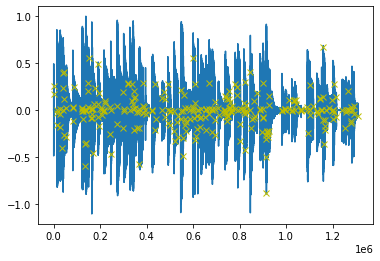

In [14]:
plt.plot(x)
plt.plot(peaks,x[peaks],'x',c='y')

In [81]:
peaks1

array([  27904,   67328,  114432,  172032,  219392,  285952,  330496,
        371456,  417536,  485376,  524032,  562688,  602624,  641280,
        679680,  727808,  769024,  819456,  858880,  903936,  973568,
       1013504, 1056512, 1097216, 1139456, 1189632, 1235456, 1279488,
       1339136, 1395968, 1472512])